# 📘 01_eda_feature_engineering.ipynb

# =====================
# 1. Imports & Settings
# =====================

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# =====================
# 2. Load Dataset
# =====================

In [5]:

file_path = "../data/raw/complaints.csv"
df = pd.read_csv(file_path, low_memory=False)


# =====================
# 3. Basic Info
# =====================

In [6]:

print("Original shape:", df.shape)
df.info()
df.describe(include='all')
df.sample(5)

Original shape: (11170876, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11170876 entries, 0 to 11170875
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
1321097,2023-09-21,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,NaN,NaN,JPMORGAN CHASE & CO.,NJ,08527,NaN,Other,Web,2023-09-21,Closed with explanation,Yes,NaN,7586804
5447920,2025-07-01,Credit reporting or other personal consumer reports,Credit reporting,Incorrect information on your report,Old information reappears or never goes away,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MA,02210,NaN,Consent not provided,Web,2025-07-01,Closed with non-monetary relief,Yes,NaN,14402980
6716896,2022-09-30,Student loan,Federal student loan servicing,Struggling to repay your loan,Can't get other flexible options for repaying your loan,Navient Ffelp borrower since 2006. XXXXoan increased from XXXX to XXXX today. One of those years they put me on an ibr without telling me the ffel...,NaN,"Navient Solutions, LLC.",AR,72116,Servicemember,Consent provided,Web,2022-09-30,Closed with explanation,Yes,NaN,6038018
303296,2025-01-13,Credit reporting or other personal consumer reports,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,33068,NaN,Consent not provided,Web,2025-01-13,Closed with non-monetary relief,Yes,NaN,11508622
10121170,2016-06-03,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Aspen Yo LLC,NJ,08062,NaN,Consent not provided,Web,2016-06-26,Closed with explanation,Yes,Yes,1954150


# =====================
# 4. Missing Value Check
# =====================

In [7]:

missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("\nMissing values:\n", missing)



Missing values:
 Tags                            10506099
Consumer disputed?              10402592
Consumer complaint narrative     7848701
Company public response          5602010
Consumer consent provided?       1952298
Sub-issue                         857094
Sub-product                       235295
State                              56415
ZIP code                           30229
Company response to consumer          20
Issue                                  6
dtype: int64


# =====================
# 5. Target Class Distribution
# =====================

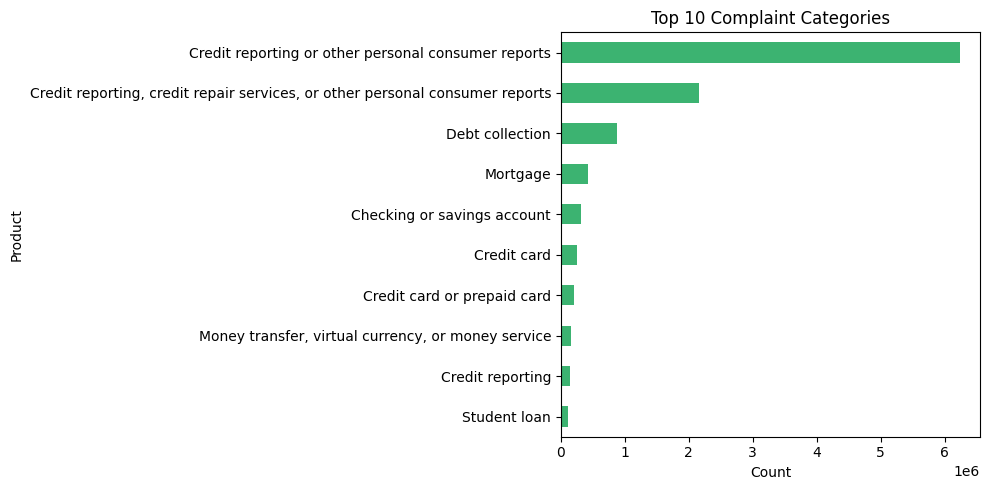

In [8]:

plt.figure(figsize=(10,5))
df['Product'].value_counts().head(10).plot(kind='barh', color='mediumseagreen')
plt.title("Top 10 Complaint Categories")
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# =====================
# 6. Filter to 4 Target Categories
# =====================

In [9]:

target_map = {
    'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, repair, or other',
    'Debt collection': 'Debt collection',
    'Consumer Loan': 'Consumer Loan',
    'Mortgage': 'Mortgage'
}


Filtered shape: (1314725, 3)


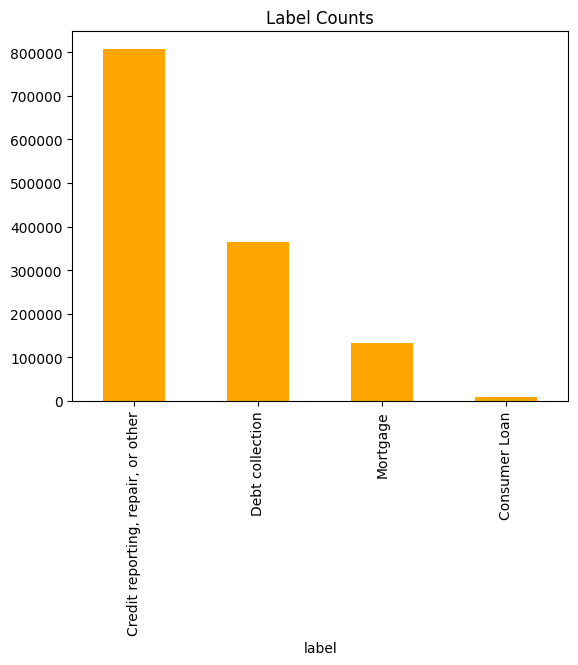

In [10]:
df = df[df['Product'].isin(target_map.keys())].copy()
df = df[['Consumer complaint narrative', 'Product']].dropna()
df['label'] = df['Product'].map(target_map)
print("\nFiltered shape:", df.shape)
df['label'].value_counts().plot(kind='bar', title='Label Counts', color='orange')
plt.show()

# =====================
# 7. Text Features (EDA Boost)
# =====================

In [11]:

df['char_count'] = df['Consumer complaint narrative'].apply(len)
df['word_count'] = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))
df['sentence_count'] = df['Consumer complaint narrative'].apply(lambda x: len(sent_tokenize(x)))
print("\nText statistics:")
print(df[['char_count', 'word_count', 'sentence_count']].describe())


Text statistics:
         char_count    word_count  sentence_count
count  1.314725e+06  1.314725e+06    1.314725e+06
mean   9.812261e+02  1.740391e+02    8.046158e+00
std    1.274840e+03  2.220174e+02    9.623613e+00
min    4.000000e+00  1.000000e+00    1.000000e+00
25%    3.320000e+02  5.900000e+01    3.000000e+00
50%    6.300000e+02  1.130000e+02    5.000000e+00
75%    1.147000e+03  2.050000e+02    9.000000e+00
max    3.261600e+04  6.095000e+03    4.010000e+02


# =====================
# 8. Complaint Length Distribution
# =====================

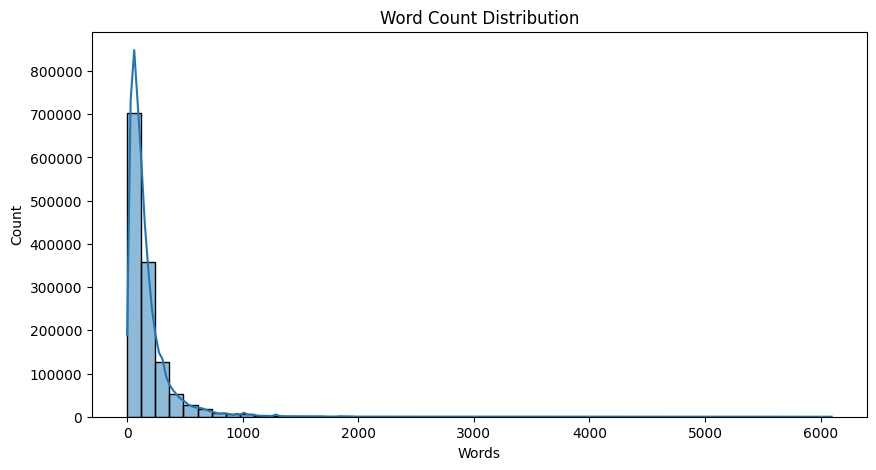

In [12]:

plt.figure(figsize=(10,5))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Words")
plt.show()

# =====================
# 9. Class Imbalance Ratio
# =====================

In [13]:

label_counts = df['label'].value_counts()
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"Class imbalance ratio: {imbalance_ratio:.2f}")


Class imbalance ratio: 85.33


# =====================
# 10. Top Complaints Per Class
# =====================

In [14]:

print("\nTop examples per class:")
for label in df['label'].unique():
    print(f"\n--- {label} ---")
    print(df[df['label'] == label]['Consumer complaint narrative'].iloc[0][:500])



Top examples per class:

--- Credit reporting, repair, or other ---
These are not my accounts.

--- Debt collection ---
This complaint is against S & S Recovery , Inc. for publishing an unauthorized debt collection account to my credit report without any form of validation, contract, or legal right to do so. I was never notified, never served, and never received my dispute rights under FDCPA 809.

They are illegally using and reporting my personal data, without consent, and are damaging my credit profile. Their failure to respond to debt validation demands and refusal to provide proper documentation qualifies as 

--- Mortgage ---
Rushmore Loan management XXXX will not permit applying for loan modification online and direct you to call. However, they do not answer the phone and the phone directs you to go online. 

I have spent hours trying to reach this company to no avail. Many times they tell you to call back during business hours but it is during business hours. 
Rushmore recently

# =====================
# 11. WordClouds by Class
# =====================

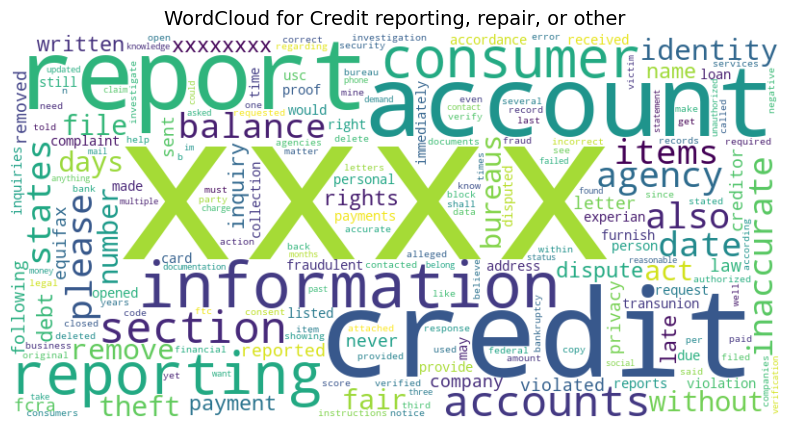

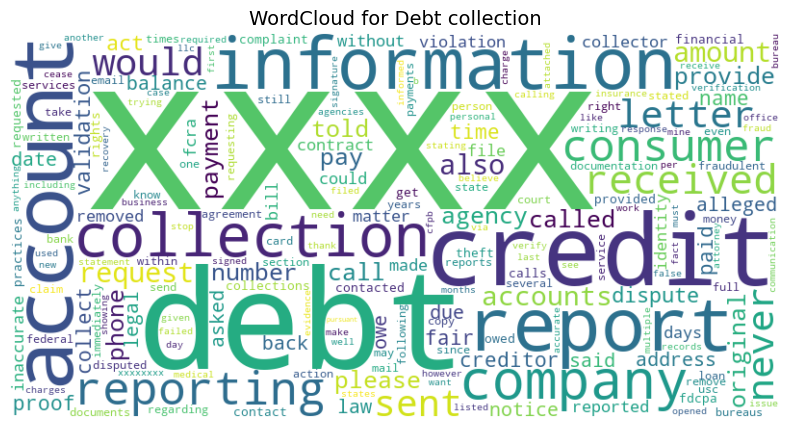

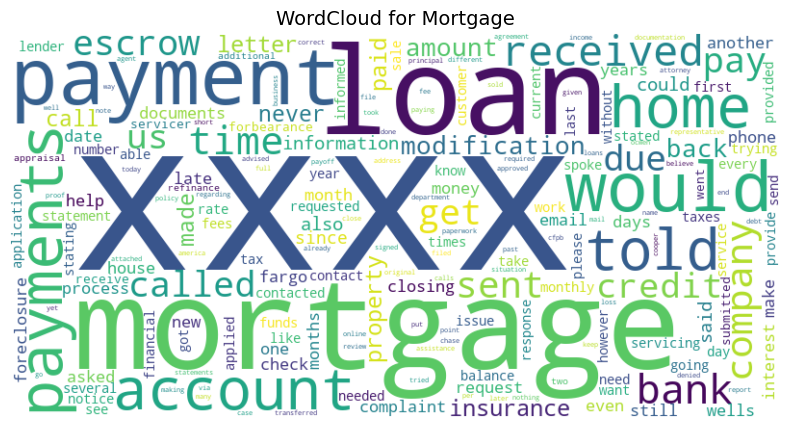

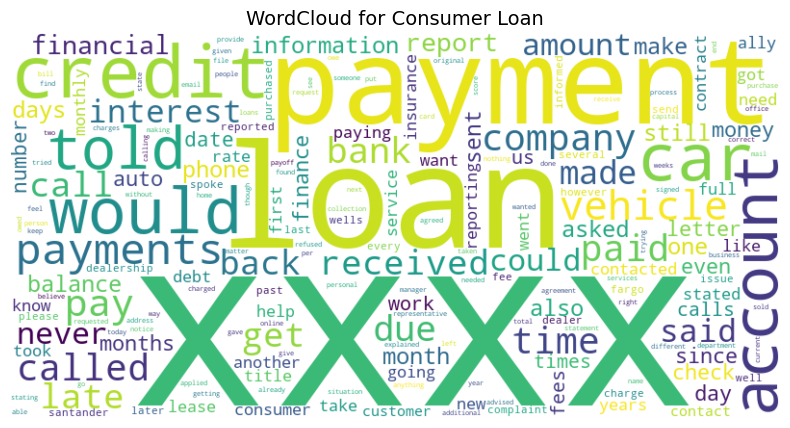

In [15]:

stop_words = set(nltk.corpus.stopwords.words('english'))

def get_wordcloud(label_name):
    text = " ".join(df[df['label'] == label_name]['Consumer complaint narrative'].astype(str))
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    freq_dist = Counter(tokens)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {label_name}", fontsize=14)
    plt.show()
for label in df['label'].unique():
    get_wordcloud(label)


# =====================
# 12. Top 20 Frequent Words
# =====================

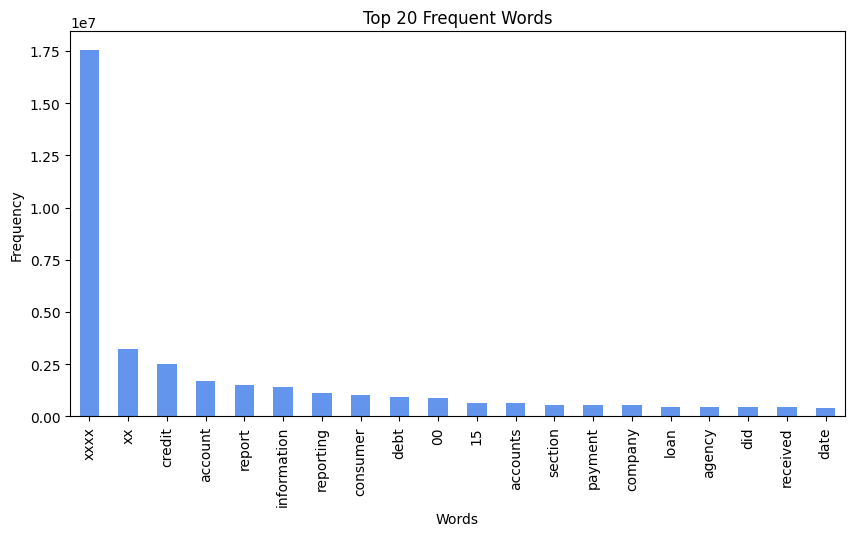

In [16]:

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['Consumer complaint narrative'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
word_freq.plot(kind='bar', color='cornflowerblue')
plt.title("Top 20 Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

# =====================
# 13. Top 10 Bigrams
# =====================


Top 10 Bigrams:
 xxxx xxxx             11204288
xx xx                  1589220
xx xxxx                1201714
credit report           784029
xxxx xx                 422722
credit reporting        355168
xxxx account            326457
account xxxx            276550
consumer reporting      274361
reporting agency        268349
dtype: int64


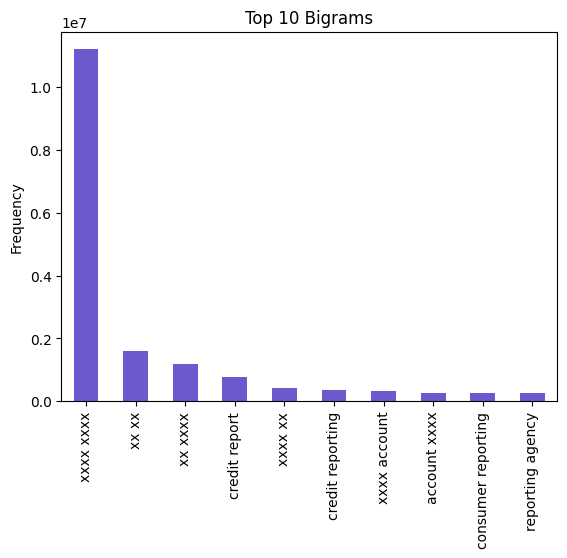

In [17]:

bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=10)
X2 = bigram_vectorizer.fit_transform(df['Consumer complaint narrative'])
bigrams = pd.DataFrame(X2.toarray(), columns=bigram_vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

print("\nTop 10 Bigrams:\n", bigrams)

bigrams.plot(kind='bar', color='slateblue', title="Top 10 Bigrams")
plt.ylabel("Frequency")
plt.show()


# =====================
# 14. Most Negative Words (using TextBlob)
# =====================

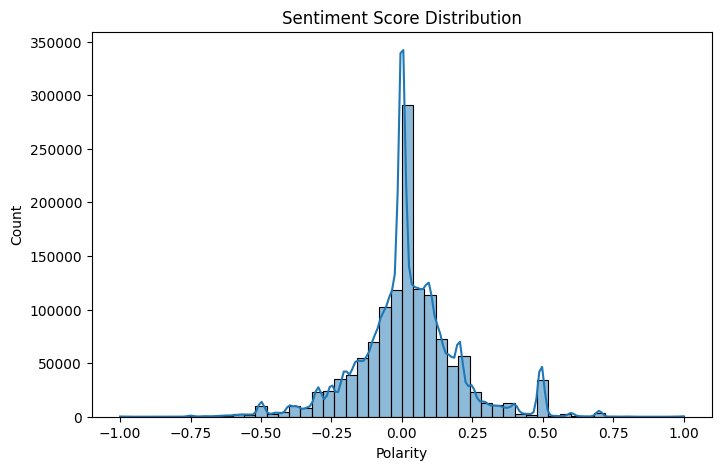

In [18]:

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['Consumer complaint narrative'].apply(get_sentiment)

plt.figure(figsize=(8,5))
sns.histplot(df['sentiment'], kde=True, bins=50)
plt.title("Sentiment Score Distribution")
plt.xlabel("Polarity")
plt.show()

In [19]:
print("\nMost negative samples:")
print(df.nsmallest(5, 'sentiment')[['Consumer complaint narrative', 'sentiment']])


Most negative samples:
                                                                                                                                 Consumer complaint narrative  \
3922    There are terrible mistakes in my report, these accounts do not relate to any transaction that I have made :   XXXX   XXXX   XXXX   XXXX   XXXX   ...   
88875   Transunion has the worst customer service ever I called to ask about a account I never seen before because I got a alert and the dispute departmen...   
117427  Someone used my information without my authorization to get a house or apartment and now they are coming after me and tarnishing my credit report....   
318042  i had started receiving letters from this company that I have never done any business with and then I started getting phone calls from this compan...   
557958  Repeat phone calls and text messages to family members. Workplace phone calls. I am a XXXX XXXX XXXX man and theyre calling my parents 2500 miles ...   

        s

# =====================
# 15. Save Processed Dataset
# =====================

In [20]:

df[['Consumer complaint narrative', 'label']].to_csv("../data/processed/cleaned_complaints.csv", index=False)
print("✅ Cleaned dataset saved to: data/processed/cleaned_complaints.csv")

✅ Cleaned dataset saved to: data/processed/cleaned_complaints.csv
